# Phase 5: Level 3 - Expert Specialization Models (VERSION LINÉAIRE)

Dans ce notebook, nous testons un modèle plus simple (**Logistic Regression**) pour l'expert DoS afin de voir si cela produit des résultats plus modestes et réalistes que la Random Forest.

In [1]:
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

processed_path = "../data/processed/"
models_path = "../data/trained_models/level3/"
os.makedirs(models_path, exist_ok=True)

print("Chargement des données...")
X_raw = joblib.load(os.path.join(processed_path, "X_unscaled.joblib"))
y_lvl3 = joblib.load(os.path.join(processed_path, "y_lvl3.joblib"))

# --- ANTI-OVERFITTING AVANCÉ ---
cols_to_drop = ['Destination Port', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward']
existing_drops = [c for c in cols_to_drop if c in X_raw.columns]
X_raw = X_raw.drop(columns=existing_drops)
print(f"Colonnes supprimées : {existing_drops}")

print(f"Données chargées. Shape: {X_raw.shape}")

Chargement des données...
Colonnes supprimées : ['Destination Port', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward']
Données chargées. Shape: (2827876, 59)


### Fonction de Diagnostic : Feature Importance / Coefs
Cette fonction nous dira quelle colonne le modèle utilise le plus.

In [2]:
def plot_importance(model, features, title):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print(f"Le modèle {title} n'a pas d'attributions d'importance.")
        return
    
    indices = np.argsort(importances)[-10:] # Top 10
    plt.figure(figsize=(10, 5))
    plt.title(f"Top 10 Features - {title}")
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Importance Relative / Coeff')
    plt.show()

## 1. EXPERT: DoS Family 
Hulk, GoldenEye, slowloris, Slowhttptest.

In [3]:
from sklearn.svm import LinearSVC

# --- Sélection des sous-classes DoS ---
dos_labels = ["DoS Hulk", "DoS GoldenEye", "DoS slowloris", "DoS Slowhttptest"]
mask_dos = y_lvl3.isin(dos_labels)
X_dos_raw = X_raw[mask_dos]
y_dos_raw = y_lvl3[mask_dos]

# --- Encodage des labels ---
le_dos = LabelEncoder()
y_dos = le_dos.fit_transform(y_dos_raw)

# --- Split train / val / test ---
X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(
    X_dos_raw, y_dos, test_size=0.30, random_state=42, stratify=y_dos
)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_temp_raw, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# --- Scaling LOCAL ---
scaler_dos = StandardScaler()
X_train = scaler_dos.fit_transform(X_train_raw)
X_val = scaler_dos.transform(X_val_raw)
X_test = scaler_dos.transform(X_test_raw)

# --- Modèle LinearSVC ---
svm_dos = LinearSVC(
    class_weight='balanced',
    random_state=42,
    max_iter=5000  # s'assurer convergence
)
svm_dos.fit(X_train, y_train)

# --- Évaluation ---
print("--- DoS Expert Test Report (LinearSVM) ---")
y_test_pred = svm_dos.predict(X_test)
print(classification_report(y_test, y_test_pred, target_names=le_dos.classes_))

# --- Sauvegarde ---
joblib.dump(svm_dos, os.path.join(models_path, 'model_lvl3_dos_svm.joblib'))
joblib.dump(le_dos, os.path.join(models_path, 'le_lvl3_dos_svm.joblib'))
joblib.dump(scaler_dos, os.path.join(models_path, 'scaler_lvl3_dos_svm.joblib'))


c:\Users\Roua\Desktop\IDS\venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


--- DoS Expert Test Report (LinearSVM) ---
                  precision    recall  f1-score   support

   DoS GoldenEye       0.98      0.99      0.98      1544
        DoS Hulk       1.00      1.00      1.00     34519
DoS Slowhttptest       0.97      0.98      0.97       825
   DoS slowloris       0.98      0.97      0.97       869

        accuracy                           1.00     37757
       macro avg       0.98      0.98      0.98     37757
    weighted avg       1.00      1.00      1.00     37757



c:\Users\Roua\Desktop\IDS\venv\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


['../data/trained_models/level3/scaler_lvl3_dos_svm.joblib']

## 2. EXPERT: BruteForce Family
FTP-Patator, SSH-Patator, Web Attack Brute Force.

--- BruteForce Expert Test Report ---
                        precision    recall  f1-score   support

           FTP-Patator       1.00      1.00      1.00      1191
           SSH-Patator       0.98      0.99      0.98       884
Web Attack Brute Force       0.96      0.92      0.94       226

              accuracy                           0.99      2301
             macro avg       0.98      0.97      0.97      2301
          weighted avg       0.99      0.99      0.99      2301



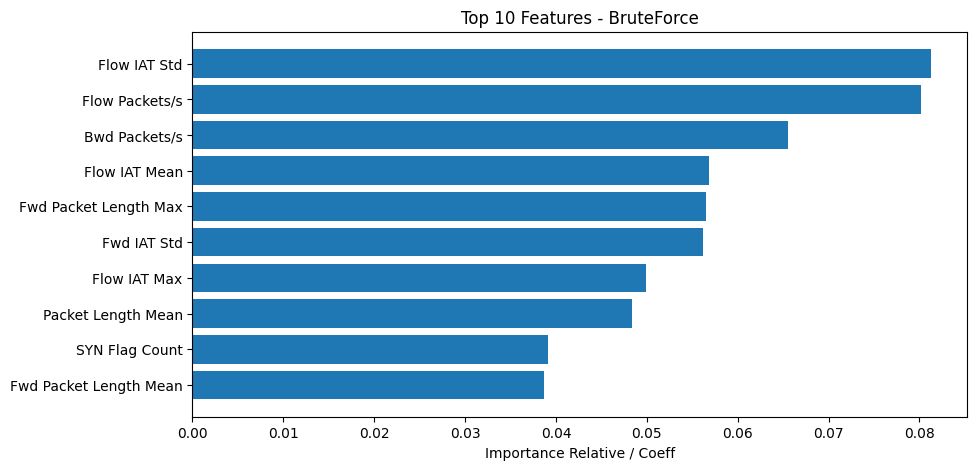

['../data/trained_models/level3/scaler_lvl3_bruteforce.joblib']

In [4]:
bruteforce_labels = ["FTP-Patator", "SSH-Patator", "Web Attack Brute Force"]
mask_bf = y_lvl3.isin(bruteforce_labels)
X_bf_raw = X_raw[mask_bf]
y_bf_raw = y_lvl3[mask_bf]

le_bf = LabelEncoder()
y_bf = le_bf.fit_transform(y_bf_raw)

X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(X_bf_raw, y_bf, test_size=0.30, random_state=42, stratify=y_bf)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(X_temp_raw, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

scaler_bf = StandardScaler()
X_train = scaler_bf.fit_transform(X_train_raw)
X_val = scaler_bf.transform(X_val_raw)
X_test = scaler_bf.transform(X_test_raw)

rf_bf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf_bf.fit(X_train, y_train)

print("--- BruteForce Expert Test Report ---")
y_test_pred = rf_bf.predict(X_test)
print(classification_report(y_test, y_test_pred, target_names=le_bf.classes_))

plot_importance(rf_bf, X_bf_raw.columns, "BruteForce")

joblib.dump(rf_bf, os.path.join(models_path, 'model_lvl3_bruteforce.joblib'))
joblib.dump(le_bf, os.path.join(models_path, 'le_lvl3_bruteforce.joblib'))
joblib.dump(scaler_bf, os.path.join(models_path, 'scaler_lvl3_bruteforce.joblib'))

## 3. EXPERT: WebAttack Family
Web Attack XSS, Web Attack Sql Injection.

--- WebAttack Expert Test Report ---
                          precision    recall  f1-score   support

Web Attack Sql Injection       0.60      1.00      0.75         3
          Web Attack XSS       1.00      0.98      0.99        98

                accuracy                           0.98       101
               macro avg       0.80      0.99      0.87       101
            weighted avg       0.99      0.98      0.98       101



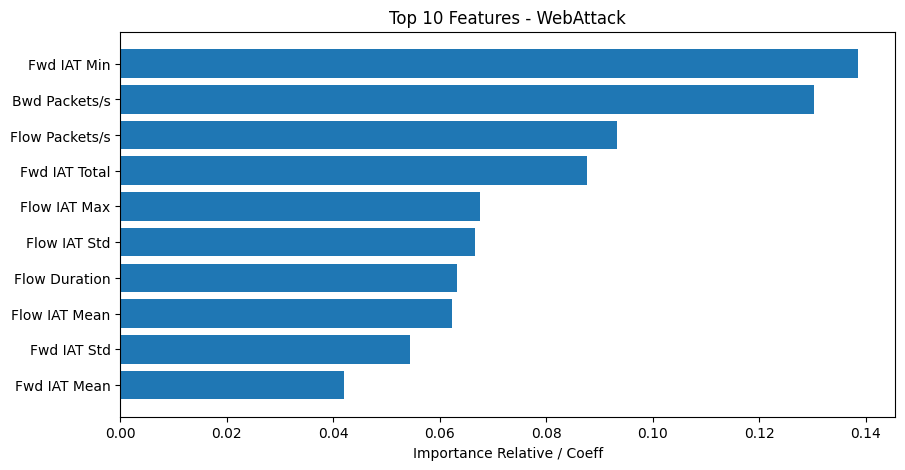

['../data/trained_models/level3/scaler_lvl3_webattack.joblib']

In [5]:
web_labels = ["Web Attack XSS", "Web Attack Sql Injection"]
mask_web = y_lvl3.isin(web_labels)
X_web_raw = X_raw[mask_web]
y_web_raw = y_lvl3[mask_web]

le_web = LabelEncoder()
y_web = le_web.fit_transform(y_web_raw)

X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(X_web_raw, y_web, test_size=0.30, random_state=42, stratify=y_web)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(X_temp_raw, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

scaler_web = StandardScaler()
X_train = scaler_web.fit_transform(X_train_raw)
X_val = scaler_web.transform(X_val_raw)
X_test = scaler_web.transform(X_test_raw)

rf_web = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf_web.fit(X_train, y_train)

print("--- WebAttack Expert Test Report ---")
y_test_pred = rf_web.predict(X_test)
print(classification_report(y_test, y_test_pred, target_names=le_web.classes_))

plot_importance(rf_web, X_web_raw.columns, "WebAttack")

joblib.dump(rf_web, os.path.join(models_path, 'model_lvl3_webattack.joblib'))
joblib.dump(le_web, os.path.join(models_path, 'le_lvl3_webattack.joblib'))
joblib.dump(scaler_web, os.path.join(models_path, 'scaler_lvl3_webattack.joblib'))

## 4. EXPERT: RareAttacks Family
Infiltration, Heartbleed.

In [ ]:
rare_labels = ["Infiltration", "Heartbleed"]
mask_rare = y_lvl3.isin(rare_labels)
X_rare_raw = X_raw[mask_rare]
y_rare_raw = y_lvl3[mask_rare]

le_rare = LabelEncoder()
y_rare = le_rare.fit_transform(y_rare_raw)

scaler_rare = StandardScaler()
X_rare = scaler_rare.fit_transform(X_rare_raw)

rf_rare = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42, n_jobs=-1)
rf_rare.fit(X_rare, y_rare)

print("--- Rare Expert Report ---")
y_pred = rf_rare.predict(X_rare)
print(classification_report(y_rare, y_pred, target_names=le_rare.classes_))

joblib.dump(rf_rare, os.path.join(models_path, 'model_lvl3_rare.joblib'))
joblib.dump(le_rare, os.path.join(models_path, 'le_lvl3_rare.joblib'))
joblib.dump(scaler_rare, os.path.join(models_path, 'scaler_lvl3_rare.joblib'))

--- Rare Expert Report ---
              precision    recall  f1-score   support

  Heartbleed       1.00      1.00      1.00        11
Infiltration       1.00      1.00      1.00        36

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47



['../data/trained_models/level3/scaler_lvl3_rare.joblib']

: 